In [1]:
from debias_transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm, trange

import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pycm import ConfusionMatrix

import os
import sys 
sys.path.insert(0, os.path.abspath(os.path.join('..')))
from train import Train as RobBERTTrainer
from textdataset import TextDataset, load_and_cache_examples

In [2]:

# %load_ext autoreload
# %autoreload 2
import debias_finetunning as sen_debias

In [3]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robBERT-base")

INFO:debias_transformers.tokenization_utils_base:Model name 'pdelobelle/robBERT-base' not found in model shortcut name list (roberta-base, roberta-large, roberta-large-mnli, distilroberta-base, roberta-base-openai-detector, roberta-large-openai-detector). Assuming 'pdelobelle/robBERT-base' is a path, a model identifier, or url to a directory containing tokenizer files.
INFO:debias_transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/vocab.json from cache at /home/ubuntu/.cache/torch/transformers/dc380186a811c183c3e4c18f48dcb0ccc43b3911653369b7e5ed1b4c6d248931.6a4061e8fc00057d21d80413635a86fdcf55b6e7594ad9e25257d2f99a02f4be
INFO:debias_transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/merges.txt from cache at /home/ubuntu/.cache/torch/transformers/e5cbecfea4fc4f89fc09c0cb9c97c6093599463446706de81f575ffd1b19deb2.70bec105b4158ed9a1747fea67a43

In [4]:
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robBERT-base")
logging.info("loaded RobBERT")

INFO:debias_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/config.json from cache at /home/ubuntu/.cache/torch/transformers/09385ae6c6a71a27f2346100bcf0141e76ca5a72ef7e0846896a07aee8ed222d.fdbcc22c14cda4b40b6c8a68eefccabecd218231a7f1d1fbe2a0f15c2d89331e
INFO:debias_transformers.configuration_utils:Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

INFO:debias_transformers.modeling_utils:loadi

## Create a training config

In [5]:
from train_config import Config
config = Config()
config.evaluate_dataset = "../../Rodrigo-data/Finetuning/dbrd/eval"

## Create bias direction

In [6]:
#Get bias dir

file_bias_subspace = "../../Rodrigo-data/bias_subspace/Robbert_ForFinetune-bias_subspace_k50_nl_large30000k"
bias_subspace = sen_debias.get_bias_direction(model,tokenizer, #reload from cache 
    from_cache = True,    
    filename_cache= file_bias_subspace)
bias_direction = bias_subspace[0] #just use the direction for testing   
bias_direction = torch.tensor(bias_direction).to(torch.device("cuda"))

In [7]:
bias_subspace.shape

(50, 768)

## Load in the data
We use `load_and_cache_examples` to load in the training data, this will produce a tokenized version with torch tensors.

For the test and evaluation sets, we'll use the following `evaluate` function, since we're in the end interested in a dataframe with all inputs and predictions.

In [8]:
def evaluate(dataset, model,debias,bias_dir):
    df = pd.read_table(dataset + ".labels.txt", header=None, names=['labels'])
    df['sentence'] = pd.read_table(dataset + ".sentences.txt", header=None, names=['sentence'])
    model.eval() # disable dropout etc.
    
    mask_padding_with_zero = True
    block_size = 512
    results = []

    # file_bias_subspace = "../Rodrigo-data/bias_subspace/bias_subspace_k"+str(k_dim_file)+"_nl_large"+str(pairs_aumount)+"k"
    # bias_dir = sen_debias.get_bias_direction(model_nl,tokenizer_nl,from_cache = True,filename_cache= file_bias_subspace)
    for row in tqdm(df.iterrows(), total=len(df), mininterval=1, position=1, leave=True):
        index = row[0]
        sentence = row[1]['sentence']
        label = row[1]['labels']

        #tokens = roberta.encode(sentence)

        tokenized_text = tokenizer.encode(tokenizer.tokenize(sentence)[- block_size + 3 : -1])

        input_mask = [1 if mask_padding_with_zero else 0] * len(tokenized_text)

        pad_token = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        while len(tokenized_text) < block_size:
            tokenized_text.append(pad_token)
            input_mask.append(0 if mask_padding_with_zero else 1)
            #segment_ids.append(pad_token_segment_id)
            #p_mask.append(1)

        #self.examples.append([tokenizer.build_inputs_with_special_tokens(tokenized_text[0 : block_size]), [0], [0]])
        batch = tuple(torch.tensor(t).to(torch.device("cuda")) for t in [tokenized_text[0 : block_size - 3], input_mask[0 : block_size- 3], [0], [1] if label else [0]])
        inputs = {"input_ids": batch[0].unsqueeze(0), "attention_mask": batch[1].unsqueeze(0), "labels": batch[3].unsqueeze(0),
        "remove_bias":debias,"bias_dir":bias_direction}
        with torch.no_grad():
            outputs = model(**inputs)

            results.append({"true": label, "predicted": outputs[1][0].argmax().item()})

    model.train() # make sure the model is back in training mode
    return results

In [9]:
train_dataset = load_and_cache_examples("roberta", tokenizer, "../../Rodrigo-data/Finetuning/dbrd/train")

INFO:textdataset:Creating features from dataset file at ../../Rodrigo-data/Finetuning/dbrd
../../Rodrigo-data/Finetuning/dbrd/train
INFO:textdataset:Saving features into cached file ../../Rodrigo-data/Finetuning/dbrd/roberta_cached_lm_512_train


In [10]:
model.train()
logging.info("Put RobBERT in training mode")

INFO:root:Put RobBERT in training mode


In [11]:
# You can use the following code to adjust the training size to experiment with the benefits of pretraining. It will not likely get better though ...
#train_dataset.examples  = train_dataset.examples[:100]
# 46min after iteration 1:13

In [12]:
RobBERTTrainer.train(config, train_dataset, model, tokenizer, evaluate,debias=True, bias_dir=bias_direction)

INFO:train:***** Running training *****
INFO:train:  Num examples = 19528
INFO:train:  Num Epochs = 4
INFO:train:  Instantaneous batch size per GPU = 4
INFO:train:  Total train batch size (w. parallel, distributed & accumulation) = 32
INFO:train:  Gradient Accumulation steps = 8
INFO:train:  Total optimization steps = 2000
Iteration: 100%|██████████| 4882/4882 [31:32<00:00,  2.58it/s, learning_rate=3.97e-5, loss=0.21, step=610]


TypeError: evaluate() missing 2 required positional arguments: 'debias' and 'bias_dir'

## Evaluate our trained model

In [13]:
model.eval()
logging.info("putting model in eval mode")

INFO:root:putting model in eval mode


In [14]:
results = pd.DataFrame(evaluate("../../Rodrigo-data/Finetuning/dbrd/test", model,debias=True, bias_dir=bias_direction))


100%|██████████| 2224/2224 [03:58<00:00,  9.31it/s]


In [15]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, aspect="equal")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(len(tick_marks) - 0.5, -0.5)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1053   59]
 [ 135  977]]


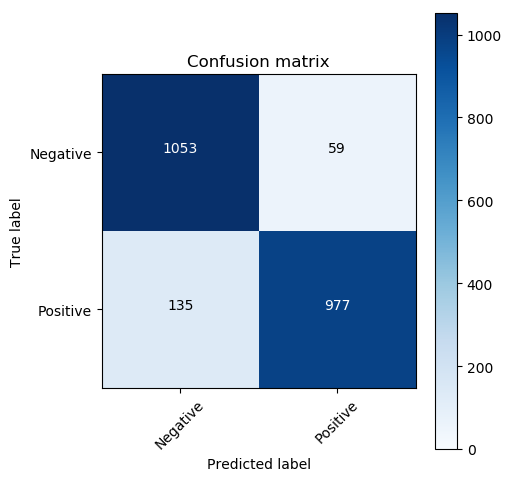

In [16]:
cnf_matrix = confusion_matrix(results['true'], results['predicted'] ) # index to evaluate partial runs

np.set_printoptions(precision=2)

title="Confusion matrix"

# Plot normalized confusion matrix
fig = plt.figure(figsize=(5,5), dpi=100)
#fig.set_size_inches(6,6)

plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"],normalize=False, 
                      title=title, cmap=plt.cm.Blues)


In [17]:
cm = ConfusionMatrix(actual_vector=results['true'].values, predict_vector=results['predicted'].values )

In [18]:
cm.stat()

Overall Statistics : 

95% CI                                                            (0.90104,0.9245)
ACC Macro                                                         0.91277
ARI                                                               0.68137
AUNP                                                              0.91277
AUNU                                                              0.91277
Bangdiwala B                                                      0.83432
Bennett S                                                         0.82554
CBA                                                               0.88248
CSI                                                               0.82748
Chi-Squared                                                       1522.80379
Chi-Squared DF                                                    1
Conditional Entropy                                               0.41631
Cramer V                                                          0.82747
Cross Ent

In [34]:
import pickle
file_pickle_stats =  "../../Rodrigo-data/Finetuning/dbrd/v2/cm_stat_robbert_debiased"
pickle.dump( cm, open(file_pickle_stats+".p", "wb" ))
st_test =pickle.load( open(file_pickle_stats+".p", "rb" ))
cm.save_csv(file_pickle_stats) #save csv for easy to read


{'Status': True,
 'Message': '/home/ubuntu/thesis/Rodrigo-Debias-Dutch-Embeddings/Rodrigo-notebooks/Finetuning/../../Rodrigo-data/Finetuning/dbrd/v2/cm_stat_robbert_debiased.csv'}

## Saving the model

In [35]:
from transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = "../../Rodrigo-data/Finetuning/dbrd/v2/robbert_debiased/"

# Step 1: Save a model, configuration and vocabulary that you have fine-tuned

# If we have a distributed model, save only the encapsulated model
# (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)

('../../Rodrigo-data/Finetuning/dbrd/v2/robbert_debiased/vocab.json',
 '../../Rodrigo-data/Finetuning/dbrd/v2/robbert_debiased/merges.txt')